In [ ]:
import pandas as pd
import ast
import re
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
#Read in dataset
regression_df = pd.read_csv('Regression_Knowledgebase.csv')

In [ ]:
regression_df

,dataset_name,series_description,algorithm,hyperparameters
0,1031-29-1-1-5.csv,A multivariate regression time-series dataset ...,XGBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
1,1031-29-1-1-6.csv,A multivariate regression time-series dataset ...,ExtraTreesRegressor,"{'max_features': 'sqrt', 'min_samples_split': ..."
2,1031-54-2-1-2.csv,A multivariate regression time-series dataset ...,RandomForestRegressor,"{'max_depth': None, 'min_samples_split': 2, 'n..."
3,1031-54-2-1-3.csv,A multivariate regression time-series dataset ...,XGBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
4,1031-54-2-1-5.csv,A multivariate regression time-series dataset ...,ExtraTreesRegressor,"{'max_features': 'log2', 'min_samples_split': ..."
...,...,...,...,...
805,1031-6-3-1-1.csv,A multivariate regression time-series dataset ...,RandomForestRegressor,"{'max_depth': 20, 'n_estimators': 400, 'random..."
806,1031-59-2-1-2.csv,A multivariate regression time-series dataset ...,RandomForestRegressor,"{'max_depth': None, 'min_samples_split': 2, 'n..."
807,1031-59-2-1-3.csv,A multivariate regression time-series dataset ...,RandomForestRegressor,"{'max_depth': None, 'min_samples_split': 2, 'n..."
808,1031-59-2-1-5.csv,A multivariate regression time-series dataset ...,XGBoostRegressor,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."


In [ ]:
#Check example of series_descripiton
regression_df["series_description"][0]

'A multivariate regression time-series dataset consists of 7464 instances and 17 features. The percentage of numerical features to categorical features in the dataset is 2.2  The dataset has a sampling rate of 60.0 minutes. The percentage of missing values in the target column is 0.19%. he missing values percentages for numerical features range from 1400% to 211200% with mean 20472.73%, and standard deviation 63257.08%.Similarly, the missing values percentages for categorical features range from 1400% to 1400% with mean 1400.0%, and standard deviation 0.0%. The target series has a minimum value 19.9, maximum value 35.1, median 25.2, mean 26.153865275372308, and average standard deviation of 0.2014286746341122 for the 10 percentiles. The series is detected as stationary using dickey fuller test . The series has 10 significant lags observed using the partial autocorrelation function (pACF), the pACF values for these 10 lags ranges from 0.9366106168100137 for the lag number 1 to -0.065048

In [ ]:
#Check example of hyperparameters
regression_df["hyperparameters"][0]

"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'random_state': 42, 'subsample': 0.8}"

NB! We don't actually need the model hyperparameters for this task, because it is actually a classification task to predict the model and we do not have the scores available that could be used to predict the best hyperparameters. The following code was used originally to convert hyperparameters column to tabular data features. It has been commented out because it is not needed.

In [ ]:
#Convert hyperparameters column to tabular data
#def safe_literal_eval(item):
#    # Ensure the item is a string before attempting literal_eval
#    if isinstance(item, str):
#        try:
#            return ast.literal_eval(item)
#        except (ValueError, SyntaxError):
#            # If parsing fails, return an empty dictionary to handle malformed strings
#            return {}
#    # If the item is not a string (e.g., already a dict or NaN from prior processing),
#    # return an empty dict as it's not a parsable string representation.
#    return {}

#Apply the function to get a dictionary for the hyperparameters of each row
#regression_df['hyperparameters'] = regression_df['hyperparameters'].apply(safe_literal_eval)

#Create new tabualar features from the dictionary
#expanded_hyperparameters = pd.json_normalize(regression_df['hyperparameters'])
#regression_df = pd.concat([regression_df, expanded_hyperparameters], axis=1)

#Drop original hyperparameters column
regression_df.drop('hyperparameters', axis=1, inplace=True)


Convert series_description column to tabular data features

In [ ]:
def extract_core_stats(description):
    stats = {}

    # Number of instances
    match = re.search(r'dataset consists of (\d+) instances', description)
    if match: stats['num_instances'] = int(match.group(1))

    # Number of features
    match = re.search(r'and (\d+) features', description)
    if match: stats['num_features'] = int(match.group(1))

    # Percentage of numerical features to categorical features
    match = re.search(r'percentage of numerical features to categorical features in the dataset is (\d+\.?\d*)', description)
    if match: stats['num_to_cat_ratio'] = float(match.group(1))

    # Sampling rate
    match = re.search(r'dataset has a sampling rate of (\d+\.?\d*) minutes', description)
    if match: stats['sampling_rate'] = float(match.group(1))

    # Missing values in the target column
    match = re.search(r'percentage of missing values in the target column is (\d+\.?\d*)%', description)
    if match: stats['target_missing_percent'] = float(match.group(1))

    return stats

# Apply the function to the 'series_description' column
extracted_stats_df = regression_df['series_description'].apply(extract_core_stats).apply(pd.Series)

# Concatenate the new columns with the original dataframe
regression_df = pd.concat([regression_df, extracted_stats_df], axis=1)

def extract_missing_value_stats(description):
    stats = {}

    # Numerical features missing value percentages
    # The missing values percentages for numerical features range from 0% to 217200% with mean 19745.45%, and standard deviation 65488.26%.
    num_mv_match = re.search(r'missing values percentages for numerical features range from (\d+\.?\d*)% to (\d+\.?\d*)% with mean (\d+\.?\d*)%, and standard deviation (\d+\.?\d*)%', description)
    if num_mv_match:
        stats['num_mv_min'] = float(num_mv_match.group(1))
        stats['num_mv_max'] = float(num_mv_match.group(2))
        stats['num_mv_mean'] = float(num_mv_match.group(3))
        stats['num_mv_std'] = float(num_mv_match.group(4))

    # Categorical features missing value percentages
    # Similarly, the missing values percentages for categorical features range from 0% to 0% with mean 0.0%, and standard deviation 0.0%.
    cat_mv_match = re.search(r'missing values percentages for categorical features range from (\d+\.?\d*)% to (\d+\.?\d*)% with mean (\d+\.?\d*)%, and standard deviation (\d+\.?\d*)%', description)
    if cat_mv_match:
        stats['cat_mv_min'] = float(cat_mv_match.group(1))
        stats['cat_mv_max'] = float(cat_mv_match.group(2))
        stats['cat_mv_mean'] = float(cat_mv_match.group(3))
        stats['cat_mv_std'] = float(cat_mv_match.group(4))

    return stats

# Apply the function to the 'series_description' column
mv_stats_df = regression_df['series_description'].apply(extract_missing_value_stats).apply(pd.Series)

# Concatenate the new columns with the original dataframe
regression_df = pd.concat([regression_df, mv_stats_df], axis=1)


def extract_target_stats(description):
    stats = {}

    # The target series has a minimum value 18.0, maximum value 35.1, median 24.9, mean 25.9612773379847, and average standard deviation of 0.19146870962327625 for the 10 percentiles.

    # Minimum value
    match_min = re.search(r'minimum value (\d+\.?\d*)', description)
    if match_min: stats['target_min_value'] = float(match_min.group(1))

    # Maximum value
    match_max = re.search(r'maximum value (\d+\.?\d*)', description)
    if match_max: stats['target_max_value'] = float(match_max.group(1))

    # Median value
    match_median = re.search(r'median (\d+\.?\d*)', description)
    if match_median: stats['target_median_value'] = float(match_median.group(1))

    # Mean value - Corrected regex to be more specific to 'target series' mean
    match_mean = re.search(r'The target series has a.*?mean (\d+\.?\d*)', description)
    if match_mean: stats['target_mean_value'] = float(match_mean.group(1))

    # Average standard deviation for the 10 percentiles
    match_avg_std = re.search(r'average standard deviation of (\d+\.?\d*) for the 10 percentiles', description)
    if match_avg_std: stats['target_avg_std_10_percentiles'] = float(match_avg_std.group(1))

    return stats

# Apply the function to the 'series_description' column
target_stats_df = regression_df['series_description'].apply(extract_target_stats).apply(pd.Series)

# Concatenate the new columns with the original dataframe
regression_df = pd.concat([regression_df, target_stats_df], axis=1)


def extract_timeseries_characteristics(description):
    characteristics = {}

    # Stationarity
    match = re.search(r'series is detected as (stationary|not stationary) using dickey fuller test', description)
    characteristics['stationarity'] = match.group(1) if match else None

    # Significant lags
    match = re.search(r'series has (\d+) significant lags observed using the partial autocorrelation function', description)
    characteristics['significant_lags_pacf'] = int(match.group(1)) if match else None

    # Trend (multiplicative/additive and linear/non-linear)
    trend_model_match = re.search(r'(multiplicative|additive) time-series with a', description)
    trend_type_match = re.search(r'time-series with a (linear|non-linear)? trend', description)

    if trend_model_match and trend_type_match:
        characteristics['trend_model'] = trend_model_match.group(1)
        characteristics['trend_type'] = trend_type_match.group(1)
    elif 'There are no trend detected' in description: # Explicitly check for no trend
        characteristics['trend_model'] = 'None'
        characteristics['trend_type'] = 'None'
    else:
        characteristics['trend_model'] = None
        characteristics['trend_type'] = None


    # Seasonality
    match = re.search(r'There are (no|multiplicative|additive) seasonality components detected in the series', description)
    characteristics['seasonality'] = match.group(1) if match else None

    # Skewness
    match = re.search(r'skewness value of (\-?\d+\.?\d*)', description)
    characteristics['skewness'] = float(match.group(1)) if match else None

    # Kurtosis
    match = re.search(r'kurtosis value of (\-?\d+\.?\d*)', description)
    characteristics['kurtosis'] = float(match.group(1)) if match else None

    # Fractal Dimension
    match = re.search(r'Fractal dimension analysis yields a value of (\-?\d+\.?\d*)', description)
    characteristics['fractal_dimension'] = float(match.group(1)) if match else None

    return characteristics

# Apply the function to the 'series_description' column
timeseries_characteristics_df = regression_df['series_description'].apply(extract_timeseries_characteristics).apply(pd.Series)

# Concatenate the new columns with the original dataframe
regression_df = pd.concat([regression_df, timeseries_characteristics_df], axis=1)


def extract_numerical_predictor_characteristics(description):
    characteristics = {}

    # Percentage of numerical features detected as stationary
    match = re.search(r'Among the numerical predictors, the series has (\d+\.?\d*)% of the numerical features detected as stationary', description)
    characteristics['num_pred_stationary_percent'] = float(match.group(1)) if match else None

    # Seasonality components detected in numerical predictors
    # The text states either "There are no seasonality components detected" or implies they are detected.
    # A simple check for "no seasonality" should suffice to determine presence.
    match = re.search(r'There are (no) seasonality components detected in the numerical predictors', description)
    characteristics['num_pred_seasonality'] = 'no' if match else 'yes' # Assuming 'yes' if 'no' is not found

    # Skewness values for numerical predictors (min/max)
    match = re.search(r'skewness values ranging from (\-?\d+\.?\d*) to (\-?\d+\.?\d*)', description)
    if match:
        characteristics['num_pred_skewness_min'] = float(match.group(1))
        characteristics['num_pred_skewness_max'] = float(match.group(2))
    else:
        characteristics['num_pred_skewness_min'] = None
        characteristics['num_pred_skewness_max'] = None

    # Kurtosis values for numerical predictors (min/max)
    match = re.search(r'kurtosis values of (\-?\d+\.?\d*) to (\-?\d+\.?\d*)', description)
    if match:
        characteristics['num_pred_kurtosis_min'] = float(match.group(1))
        characteristics['num_pred_kurtosis_max'] = float(match.group(2))
    else:
        characteristics['num_pred_kurtosis_min'] = None
        characteristics['num_pred_kurtosis_max'] = None

    # Fractal dimension analysis values for numerical predictors (min/max)
    match = re.search(r'fractal dimension analysis yields values ranging from (\-?\d+\.?\d*) to (\-?\d+\.?\d*)', description)
    if match:
        characteristics['num_pred_fractal_dim_min'] = float(match.group(1))
        characteristics['num_pred_fractal_dim_max'] = float(match.group(2))
    else:
        characteristics['num_pred_fractal_dim_min'] = None
        characteristics['num_pred_fractal_dim_max'] = None

    # Correlation values among numerical predictors (min, max, mean, std)
    match = re.search(r'The correlation values among the numerical predictors have a minimum of (\-?\d+\.?\d*), maximum (\-?\d+\.?\d*), mean (\-?\d+\.?\d*), and standard deviation (\-?\d+\.?\d*)', description)
    if match:
        characteristics['num_pred_corr_min'] = float(match.group(1))
        characteristics['num_pred_corr_max'] = float(match.group(2))
        characteristics['num_pred_corr_mean'] = float(match.group(3))
        characteristics['num_pred_corr_std'] = float(match.group(4))
    else:
        characteristics['num_pred_corr_min'] = None
        characteristics['num_pred_corr_max'] = None
        characteristics['num_pred_corr_mean'] = None
        characteristics['num_pred_corr_std'] = None

    return characteristics

# Apply the function to the 'series_description' column
numerical_predictor_chars_df = regression_df['series_description'].apply(extract_numerical_predictor_characteristics).apply(pd.Series)

# Concatenate the new columns with the original dataframe
regression_df = pd.concat([regression_df, numerical_predictor_chars_df], axis=1)

def extract_categorical_predictor_characteristics(description):
    characteristics = {}

    # Among the categorical predictors, the count of symbols ranges from 59 to 69 with a minimum entropy value 4.971188170385047, maximum entropy 5.413463347518894, mean 5.167300989794725, and standard deviation 0.16517957966658733.

    # Count of symbols (min/max)
    match_count_symbols = re.search(r'count of symbols ranges from (\d+) to (\d+)', description)
    if match_count_symbols:
        characteristics['cat_pred_symbol_count_min'] = int(match_count_symbols.group(1))
        characteristics['cat_pred_symbol_count_max'] = int(match_count_symbols.group(2))

    # Minimum entropy value
    match = re.search(r'with a minimum entropy value (\d+\.?\d*), maximum entropy (\d+\.?\d*), mean (\d+\.?\d*), and standard deviation (\d+\.?\d*)', description)
    if match:
        characteristics['cat_pred_min_entropy'] = float(match.group(1))
        characteristics['cat_pred_max_entropy'] = float(match.group(2))
        characteristics['cat_pred_mean_entropy'] = float(match.group(3))
        characteristics['cat_pred_std_entropy'] = float(match.group(4))
    else:
        characteristics['cat_pred_min_entropy'] = None
        characteristics['cat_pred_max_entropy'] = None
        characteristics['cat_pred_mean_entropy'] = None
        characteristics['cat_pred_std_entropy'] = None

    return characteristics

# Apply the function to the 'series_description' column
categorical_predictor_chars_df = regression_df['series_description'].apply(extract_categorical_predictor_characteristics).apply(pd.Series)

# Concatenate the new columns with the original dataframe
regression_df = pd.concat([regression_df, categorical_predictor_chars_df], axis=1)


In [ ]:
#drop original series_description column and print dataframe fetures
regression_df.drop('series_description', axis=1, inplace=True)

#drop dataset_name column as it is not needed for predictions
regression_df.drop('dataset_name', axis=1, inplace=True)

print("Original 'series_description' column dropped.")
print("Consolidated DataFrame head:")
print(regression_df.head())
print("\nConsolidated DataFrame columns:")
print(regression_df.columns.tolist())

Original 'series_description' column dropped.
Consolidated DataFrame head:
               algorithm  num_instances  num_features  num_to_cat_ratio  \
0       XGBoostRegressor         7464.0          17.0              2.20   
1    ExtraTreesRegressor         7464.0          16.0              2.75   
2  RandomForestRegressor         6924.0          17.0             15.00   
3       XGBoostRegressor         6924.0          17.0             15.00   
4    ExtraTreesRegressor         6924.0          17.0              7.00   

   sampling_rate  target_missing_percent  num_mv_min  num_mv_max  num_mv_mean  \
0           60.0                    0.19      1400.0    211200.0     20472.73   
1           60.0                    0.00         0.0    217200.0     19745.45   
2           60.0                    3.48     24100.0    232200.0     39906.67   
3           60.0                    1.79     12400.0    202700.0     25746.67   
4           60.0                    0.23      1600.0    199700.0     

In [ ]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   algorithm                      810 non-null    object 
 1   num_instances                  810 non-null    float64
 2   num_features                   810 non-null    float64
 3   num_to_cat_ratio               521 non-null    float64
 4   sampling_rate                  810 non-null    float64
 5   target_missing_percent         810 non-null    float64
 6   num_mv_min                     806 non-null    float64
 7   num_mv_max                     806 non-null    float64
 8   num_mv_mean                    806 non-null    float64
 9   num_mv_std                     806 non-null    float64
 10  cat_mv_min                     370 non-null    float64
 11  cat_mv_max                     370 non-null    float64
 12  cat_mv_mean                    370 non-null    flo

Split data to train and test



In [ ]:
regression_df['algorithm'].value_counts()

,count
algorithm,
RandomForestRegressor,321
LassoRegressor,148
XGBoostRegressor,135
ExtraTreesRegressor,130
ElasticNetRegressor,44
AdaboostRegressor,21
LightgbmRegressor,10
GaussianProcessRegressor,1


In [ ]:
#Drop classes with less than 2 instances
counts = regression_df['algorithm'].value_counts()
keep_ids = counts[counts >= 2].index
df_filtered = regression_df[regression_df['algorithm'].isin(keep_ids)].copy()

In [ ]:
#Create train and test split
Y = df_filtered['algorithm']
X = df_filtered.drop('algorithm', axis=1)

#80/20% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Create random baseline

In [ ]:
# Get class distribution from training set
classes, probs = np.unique(y_train, return_counts=True)
probs = probs / probs.sum()  # class probabilities

# Generate random predictions for X_test
y_pred_random = np.random.choice(classes, size=len(X_test), p=probs)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_random)
f1 = f1_score(y_test, y_pred_random, average='macro')

print("Random baseline accuracy:", accuracy)
print("Random baseline F1:", f1)

Random baseline accuracy: 0.2037037037037037
Random baseline F1: 0.10208643007556051


Pre-process data and train a meta-model using RandomForestClassifier

In [ ]:
numeric_features = X_train.select_dtypes(include=["float64", "int", "int64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

#Impute missing values for numeric features
num_imputer = SimpleImputer(strategy="median")
X_train_num = num_imputer.fit_transform(X_train[numeric_features])
X_test_num = num_imputer.transform(X_test[numeric_features])

#Impute missing values for categorical features with a constant value
cat_imputer = SimpleImputer(strategy="constant", fill_value="Unknown")
X_train_cat_imp = cat_imputer.fit_transform(X_train[categorical_features])
X_test_cat_imp = cat_imputer.transform(X_test[categorical_features])

#Apply one-hot-encoding to categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_cat = ohe.fit_transform(X_train_cat_imp)
X_test_cat = ohe.transform(X_test_cat_imp)

#Stack categorical and numerical features for the final dataset
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])

Train random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_final, y_train)

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test_final)

In [ ]:
print("RandomForest accuracy:", accuracy_score(y_test, y_pred_rf))
print("RandomForest macro-F1:", f1_score(y_test, y_pred_rf, average="macro"))
print("Random baseline accuracy:", accuracy_score(y_test, y_pred_random))
print("Random baseline macro-F1:", f1_score(y_test, y_pred_random, average="macro"))

RandomForest accuracy: 0.6358024691358025
RandomForest macro-F1: 0.383583506195927
Random baseline accuracy: 0.2037037037037037
Random baseline macro-F1: 0.10208643007556051


Feature importance for random forest classifier

In [ ]:
# Numeric feature names
num_names = list(numeric_features)

# One-hot encoded categorical feature names
cat_names = list(ohe.get_feature_names_out(categorical_features))

# Full feature list
all_features = num_names + cat_names

In [ ]:
#feature importance scores which show how much of the model's decision power is explained by that feature (does not explain feature combinations)
importances = rf.feature_importances_

# Sort and show top 30
indices = np.argsort(importances)[::-1]

for i in indices[:30]:
    print(f"{all_features[i]}: {importances[i]:.4f}")

num_pred_fractal_dim_max: 0.0582
target_avg_std_10_percentiles: 0.0577
num_pred_corr_mean: 0.0426
num_features: 0.0390
num_instances: 0.0374
target_max_value: 0.0357
target_mean_value: 0.0346
fractal_dimension: 0.0328
num_pred_corr_min: 0.0322
num_mv_max: 0.0315
num_pred_fractal_dim_min: 0.0313
num_pred_kurtosis_min: 0.0298
num_pred_corr_std: 0.0291
num_pred_kurtosis_max: 0.0287
skewness: 0.0283
kurtosis: 0.0278
target_median_value: 0.0270
num_mv_std: 0.0268
num_pred_skewness_max: 0.0252
num_pred_skewness_min: 0.0247
num_mv_mean: 0.0246
sampling_rate: 0.0238
cat_pred_min_entropy: 0.0198
cat_pred_symbol_count_min: 0.0197
cat_pred_mean_entropy: 0.0196
num_pred_stationary_percent: 0.0195
cat_pred_symbol_count_max: 0.0184
cat_pred_std_entropy: 0.0177
cat_pred_max_entropy: 0.0175
target_min_value: 0.0167


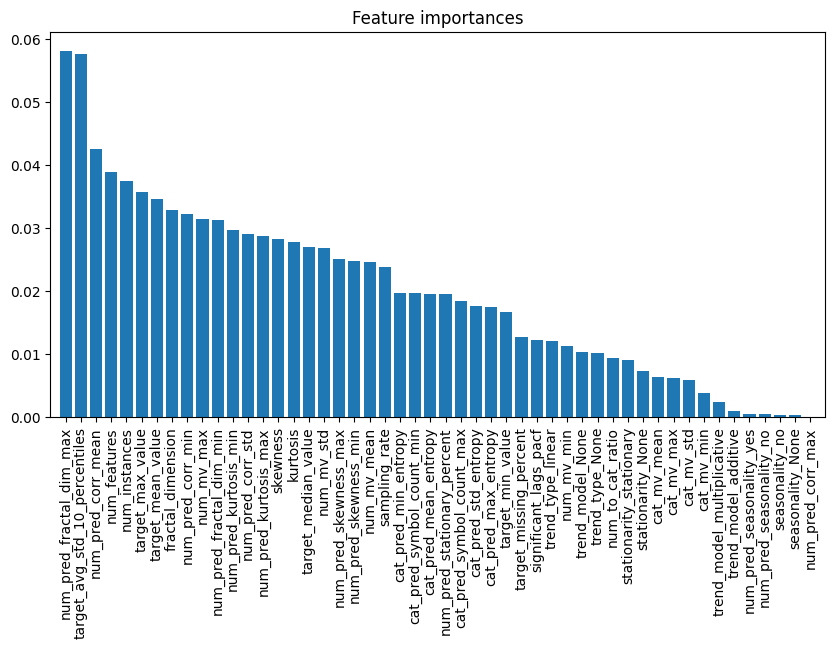

In [ ]:
### Feature importance plot for the random forest classifier
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(X_train_final.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_final.shape[1]), np.array(all_features)[indices], rotation=90)
plt.xlim([-1, X_train_final.shape[1]])
plt.show()

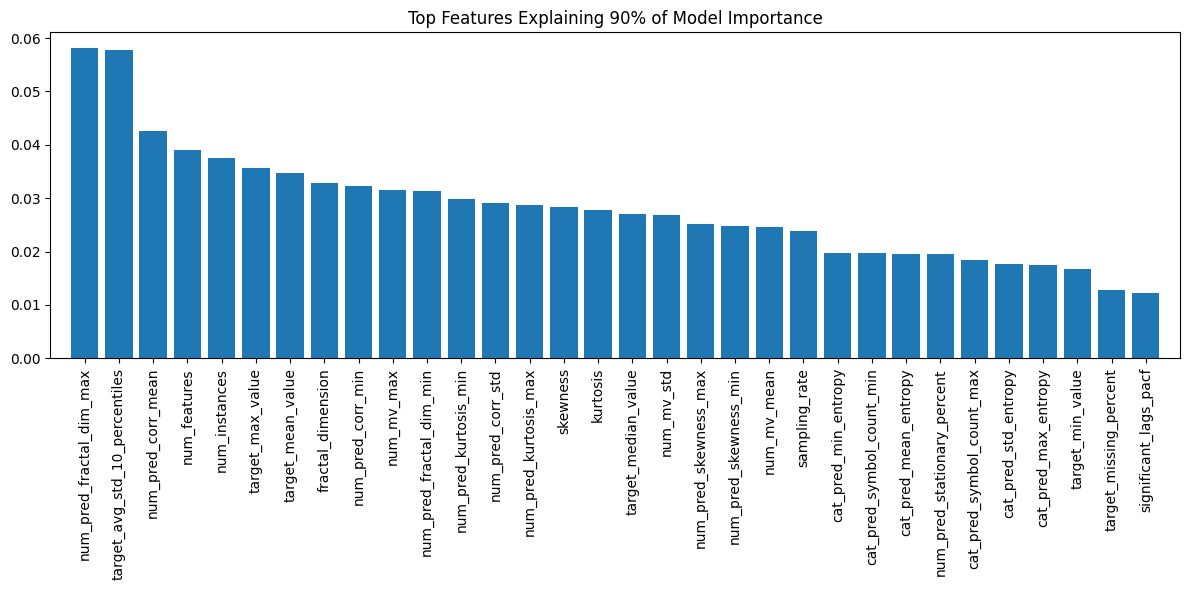

In [ ]:
#Make a plot with features that explain 90% of the model importance ( to have a more readable plot)
sorted_importances = importances[indices]
cumulative_importances = np.cumsum(sorted_importances)

ninety_percent_threshold = 0.90

# Find the index where the cumulative importance first exceeds or equals 90%
cutoff_index = np.where(cumulative_importances >= ninety_percent_threshold)[0][0]

# Get the features up to this cutoff index
important_features_90_percent = np.array(all_features)[indices[:cutoff_index + 1]]


plt.figure(figsize=(12, 6))
plt.title("Top Features Explaining 90% of Model Importance")
plt.bar(range(len(important_features_90_percent)), sorted_importances[:cutoff_index + 1], align="center")
plt.xticks(range(len(important_features_90_percent)), important_features_90_percent, rotation=90)
plt.xlim([-1, len(important_features_90_percent)])
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()